# Font Classification with PyTorch and MobileNetV3
In this notebook, we will use the PyTorch deep learning framework to train a MobileNetV3 model to classify fonts. We will use the `torchvision` library to load the dataset and the `sklearn` library to evaluate the model using accuracy, precision, recall, F1-score, and the ROC curve. We will also visualize the confusion matrix to understand the model's performance on each class.

# Imports
Import of the necessary libraries

In [1]:
import numpy as np
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import time
from sys import platform

# Model choice
Choose the model to use for training. In this case, we will use the MobileNetV3 model.

In [2]:
model_name = 'mobilenet_v3_small'
print(f'Using model: {model_name}')

Using model: mobilenet_v3_small


# Loading and preparing the dataset
Load the dataset and prepare it for training. We will resize the images to a fixed size, convert them to tensors, and normalize the pixel values.

## Preprocessing
1. Resize the images to a fixed size
2. Convert the images to tensors
3. Normalize the pixel values

In [3]:
# From the dataset, we know that the images have a height of 32 pixels and a width (on average) of 150 pixels
image_height = 32
image_width = 150

# Define the percentage of the dataset to use for training
train_size_perc = 0.7

# Set the seed for reproducibility
torch.manual_seed(0)

# Define transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),  # Resize images to a fixed size
    transforms.ToTensor(),                           # Convert images to tensors
    transforms.Normalize(mean=[0.25, 0.25, 0.25],      # Normalize pixel values
                         std=[0.25, 0.25, 0.25])])

## Load the dataset
Load the dataset using the `ImageFolder` class from `torchvision`. We will split the dataset into training, validation, and test sets. We will use 70% of the dataset for training, 15% for validation, and 15% for testing.

In [4]:
from collections import defaultdict
from torchvision.datasets import ImageFolder

# Path to the dataset
data_dir = '../../fonts'

# Notebook scope and type
scope = 'DatasetSize'
type = '200'

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Load only 20% of the dataset
# Collect indices of samples for each class
indices_by_class = defaultdict(list)
for i, (_, label) in enumerate(dataset.samples):
    indices_by_class[label].append(i)

# Choose 200 samples for each class
selected_indices = []
for indices in indices_by_class.values():
    selected_indices.extend(np.random.choice(indices, min(200, len(indices)), replace=False))

# Overwrite dataset.samples with the selected samples
dataset.samples = [dataset.samples[i] for i in selected_indices]

print(f'Loaded {len(dataset)} images')

# Display the class names
print(f'Class names: {dataset.classes}')

# Define the sizes of the training, validation, and test sets
train_size = int(train_size_perc * len(dataset))  # 70% of the dataset for training
val_size = int(((1.0 - train_size_perc)/2) * len(dataset))    # 15% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for test

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

# Define the batch size as a percentage of the training set, in this case 1%
batch_size = int(train_size * 0.01)

# Create data loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Loaded 3000 images
Class names: ['Algerian', 'Arial', 'Baskerville', 'Calibry', 'Calligraphy', 'Cambria', 'Comic Sans MS', 'Courier', 'Elephant', 'Fascinate', 'Georgia', 'Helvetica', 'Lucida Bright', 'Nasalization', 'Times New Roman']


## Dataset information

In [5]:
num_images = len(dataset)
num_batches = len(train_loader)
print(f'Number of images: {num_images}')
print(f'Number of batches: {num_batches}')
print(f'Batch size: {batch_size}')
print(f'Number of training images: {len(train_dataset)}')
print(f'Number of validation images: {len(val_dataset)}')
print(f'Number of test images: {len(test_dataset)}')

# Get the class names
class_names = dataset.classes
print(f'Class names: {class_names}')

Number of images: 3000
Number of batches: 100
Batch size: 21
Number of training images: 2100
Number of validation images: 450
Number of test images: 450
Class names: ['Algerian', 'Arial', 'Baskerville', 'Calibry', 'Calligraphy', 'Cambria', 'Comic Sans MS', 'Courier', 'Elephant', 'Fascinate', 'Georgia', 'Helvetica', 'Lucida Bright', 'Nasalization', 'Times New Roman']


# Loading the model
Load the MobileNetV3 model and move it to the device (CPU or GPU).

In [6]:
# Load the model and replace the fully connected layer
model = models.__dict__[model_name](weights=None)

# Move model to the device (CPU or GPU)
if platform != "win32":
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f'Model moved to {device}')

Model moved to cpu


# Training the model
Train the model using the training set and validate it using the validation set. We will use the Adam optimizer and the CrossEntropy loss function. We will save the model with the lowest validation loss.

In [7]:
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 60
best_val_loss = float('inf')

# Lists to store training and validation metrics for plotting
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Set the model to training mode
model.train()

# Start the training loop
start_time = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}\n-------------------------------')
    # Training phase
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Print training statistics
        if (i + 1) % 10 == 0:
            print(f'Training - Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Calculate average training loss and accuracy
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Print validation statistics
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Validation - Epoch [{epoch + 1}/{num_epochs}], Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'../../models/{scope}/{model_name}_font_classifier_{type}.pth')
        print(f'Model saved as {model_name}_font_classifier_{type}.pth')

end_time = time.time()

Epoch 1
-------------------------------
Training - Epoch [1/60], Step [10/100], Loss: 5.1446
Training - Epoch [1/60], Step [20/100], Loss: 2.4990
Training - Epoch [1/60], Step [30/100], Loss: 3.4368
Training - Epoch [1/60], Step [40/100], Loss: 2.6882
Training - Epoch [1/60], Step [50/100], Loss: 2.0384
Training - Epoch [1/60], Step [60/100], Loss: 1.8910
Training - Epoch [1/60], Step [70/100], Loss: 2.2152
Training - Epoch [1/60], Step [80/100], Loss: 1.7580
Training - Epoch [1/60], Step [90/100], Loss: 1.2744
Training - Epoch [1/60], Step [100/100], Loss: 1.4854
Validation - Epoch [1/60], Loss: 4.1408, Accuracy: 0.0467
Model saved as mobilenet_v3_small_font_classifier_200.pth
Epoch 2
-------------------------------
Training - Epoch [2/60], Step [10/100], Loss: 1.4099
Training - Epoch [2/60], Step [20/100], Loss: 1.5781
Training - Epoch [2/60], Step [30/100], Loss: 1.5403
Training - Epoch [2/60], Step [40/100], Loss: 1.2807
Training - Epoch [2/60], Step [50/100], Loss: 1.4020
Training

# Plot the training and validation metrics

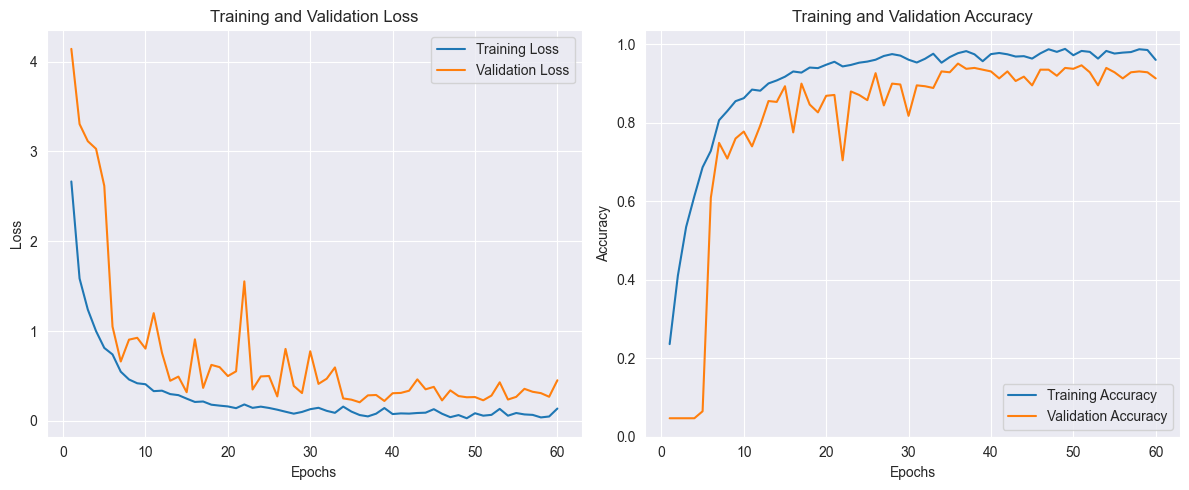

Finished Training
Time taken for training: 959.33 seconds
Medium time per epoch: 15.99 seconds


In [8]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print('Finished Training')

# Print the time taken for training
print(f'Time taken for training: {end_time - start_time:.2f} seconds')
## Print medium time per epoch
print(f'Medium time per epoch: {(end_time - start_time)/num_epochs:.2f} seconds')

# Evaluate the model

## Load the model

In [9]:
# Load the model
model_path = f'../../models/{scope}/{model_name}_font_classifier_{type}.pth'
model = models.__dict__[model_name](weights=None)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
print(f'Model loaded from {model_path}')

Model loaded from ../../models/DatasetSize/mobilenet_v3_small_font_classifier_200.pth


## Evaluate the model
Evaluate the model using the test set. We will compute the accuracy, precision, recall, F1-score, confusion matrix, and ROC curve.

In [10]:
# Set the model to evaluation mode
model.eval()

# Initialize lists for true labels and predicted labels
true_labels = []
predicted_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Perform inference
        outputs = model(images)
        
        # Compute predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Append true and predicted labels to lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

## Compute metrics
### Accuracy

In [11]:
accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy: {:.2f}%'.format(100 * accuracy))

Accuracy: 94.89%


### Precision

In [12]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
print('Precision: {:.2f}'.format(precision))

Precision: 0.95


### Recall

In [13]:
recall = recall_score(true_labels, predicted_labels, average='weighted')
print('Recall: {:.2f}'.format(recall))

Recall: 0.95


### F1-score

In [14]:
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print('F1-score: {:.2f}'.format(f1))

F1-score: 0.95


### Confusion matrix

Confusion Matrix:


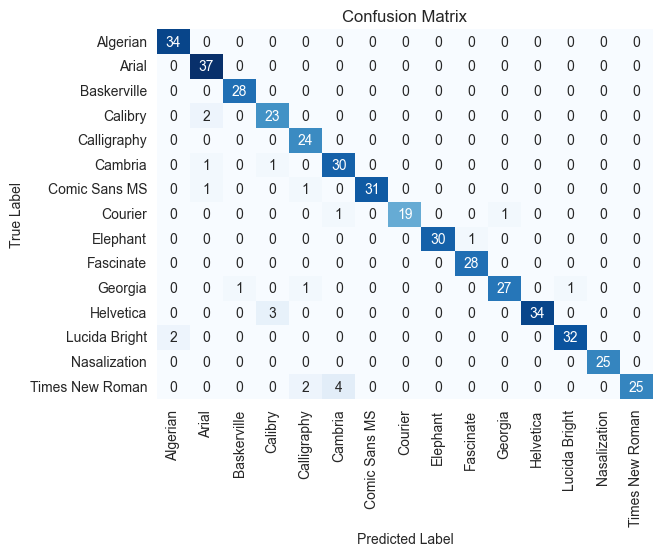

In [15]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(f'Confusion Matrix:')
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### ROC curve

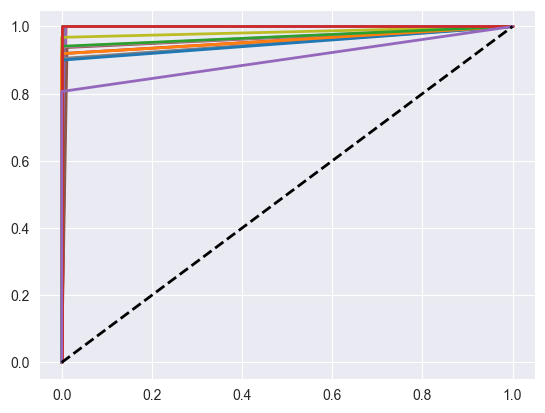

In [16]:
# Binarize the true labels
true_labels_binarized = label_binarize(true_labels, classes=range(len(class_names)))

# Binarize the predicted labels
predicted_labels_binarized = label_binarize(predicted_labels, classes=range(len(class_names)))

# Compute the ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predicted_labels_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot the ROC curve
plt.figure()
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for class {class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)